### Importing GPT2 from Hugging Faces

Details on the model:

In [2]:
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import matplotlib.pyplot as plt
import seaborn as sns


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
vocab = tokenizer.get_vocab()
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True)

print("Model name:", model.config.name_or_path)
print("Tokenizer:", tokenizer.name_or_path)
print("Vocabulary size:", tokenizer.vocab_size)
print("Embedding dimensions:", model.config.hidden_size)
print("Number of attention layers:", model.config.num_hidden_layers)

Model name: gpt2
Tokenizer: gpt2
Vocabulary size: 50257
Embedding dimensions: 768
Number of attention layers: 12


In [3]:
embeddings = model.wte.weight.data
print("Initial embedding matrix size:", tuple(embeddings.shape))      # This is the embedding matrix. Each row corresponds to a token in the vocabulary.
embeddings[11]

Initial embedding matrix size: (50257, 768)


tensor([ 1.1497e-02, -2.9490e-03,  3.2314e-02,  5.5183e-02,  5.2392e-02,
        -6.0363e-02, -2.3997e-01, -1.7334e-02,  3.8838e-02,  4.0289e-02,
        -3.2901e-03,  1.9730e-02, -2.1079e-02, -3.7016e-03, -1.9246e-02,
         3.7273e-02, -4.8122e-02, -3.3349e-02,  1.0537e-02,  2.0797e-01,
        -8.2787e-02, -1.0692e-02, -4.8333e-02, -3.7857e-02,  7.9460e-02,
         3.0554e-02, -3.8337e-02,  1.1336e-02, -4.2484e-02, -2.8114e-02,
         4.6458e-02,  6.6223e-04,  1.8305e-02, -7.2216e-02,  3.8865e-02,
         4.0108e-02, -3.1543e-01, -7.5379e-02, -1.5715e-02,  3.2486e-02,
         1.6226e-02,  3.1688e-02, -2.5208e-02, -1.0170e-01, -3.9139e-02,
        -4.1878e-02,  4.5673e-02,  3.7798e-02, -4.8963e-02, -7.3122e-02,
        -4.0856e-02,  5.5752e-02,  6.5839e-02,  4.0031e-02, -2.0230e-02,
        -1.1294e-01, -2.1563e-02, -3.6031e-02,  3.3491e-02, -3.1375e-02,
        -9.6931e-02, -3.3430e-02, -4.8675e-02,  6.8246e-03, -5.6962e-01,
         7.1983e-02, -2.7708e-02, -3.9506e-02,  1.4

In [4]:
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo Galilei."

# encode the prompt. It will return a dictionary with the input ids and attention mask
encodedPrompt = tokenizer(prompt, return_tensors='pt')   # convert to pytorch tensor
totToken = len(encodedPrompt["input_ids"][0])  
print("Prompt:", prompt)
print("Total tokens in prompt:", totToken)

print("Token that GPT2 will see:", end = ": ")
for tokenId in encodedPrompt["input_ids"][0].numpy():
    #print(tokenizer.convert_ids_to_tokens([tokenId]), end = " ")
    print(tokenizer.decode(tokenId), end = " | ")

Prompt: I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo Galilei.
Total tokens in prompt: 44
Token that GPT2 will see:: I | 'm |  an |  Italian |  physicist |  who |  lived |  in |  Pad | ua | . |  I |  am |  known |  for |  my |  work |  in |  the |  field |  of |  optics |  and |  astronomy | . |  I |  was |  born |  in |  15 | 64 |  and |  died |  in |  16 | 42 | . |  My |  name |  is |  Galileo |  Galile | i | . | 

Now let's make some predictions


In [5]:
inputs = tokenizer(prompt, return_tensors="pt")

# This is a one-hot encoding of the input ids. Basically we have ten rows and 50257 columns. Each row corresponds to a token in the vocabulary and
# each column corresponds to a token in the input sequence. Each row has only one 1
T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
# It is useful to compute the embedding matrix
X = torch.matmul(T,embeddings)
# This is the N X D matrix (N = context size, D = embedding dimension)
print(f"\nInitial embedded sequence {tuple(X.shape)}:\n{X}")

#print("\nThe first four tokens in the prompt are:")
#embeddings[vocab[prompt[0:2]],:][0:4]


Initial embedded sequence (44, 768):
tensor([[ 0.1474, -0.0959,  0.1430,  ...,  0.1030, -0.0625, -0.1131],
        [-0.0750, -0.0399,  0.1576,  ...,  0.0805, -0.0924,  0.0888],
        [-0.0870, -0.0117,  0.0687,  ...,  0.0332,  0.0562, -0.0843],
        ...,
        [-0.1884, -0.1691,  0.0439,  ...,  0.0389,  0.0418, -0.2115],
        [ 0.0125, -0.0498,  0.1088,  ...,  0.2399, -0.1205, -0.1070],
        [ 0.0466, -0.0113,  0.0283,  ..., -0.0735,  0.0496,  0.0963]])


Now, let's try to predict some tokens

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


The initial embedding matrix is:
tensor([[ 0.1286, -0.2933,  0.1470,  ...,  0.0599, -0.0342, -0.0586],
        [-0.0510, -0.0937,  0.0627,  ...,  0.1147, -0.0822,  0.0886],
        [-0.0828, -0.0964,  0.1232,  ...,  0.0530,  0.0755, -0.1057],
        ...,
        [-0.1833, -0.1549,  0.0666,  ...,  0.0394,  0.0394, -0.2151],
        [ 0.0135, -0.0471,  0.1403,  ...,  0.2450, -0.1246, -0.1103],
        [ 0.0516, -0.0053,  0.0567,  ..., -0.0727,  0.0459,  0.0900]])
It's different from the one we computed before because positional encoding

This is an attention matrix from the first layer, the third head


[]

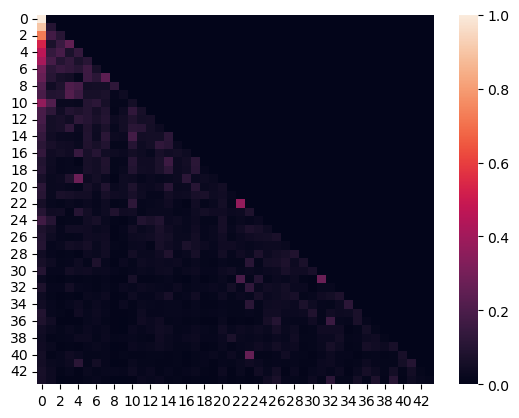

In [6]:
# The input to the model is a dictionary with the input ids and attention mask (the one returned by the tokenizer)
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

# The hidden states are a tuple of tensors. Each tensor corresponds to the output of each layer in the model. 
# The first tensor is the output of the embedding layer
embeddedTokensFirstLayer = hidden_states[0][0]
print(f"The initial embedding matrix is:")
print(embeddedTokensFirstLayer)
print("It's different from the one we computed before because positional encoding")

# Only get from the second layer to the last layer
layers = hidden_states[1:]
# attentions is a tuple of tensors. Each tensor is 12 attention maps of 16x16 matrices.
attentions = outputs.attentions

print(f"\nThis is an attention matrix from the first layer, the third head")
sns.heatmap(attentions[0][0][2])
plt.plot()

EVOLUTION OF TOKEN 40, namely ' Galileo'
I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo ...

LAYER 0 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.066
 -> 0.11: ','
 -> 2.46: '-'
 -> 4.31: ' and'
 -> 6.14: '.'
 -> 6.59: ''s'
 -> 9.80: ' in'
 -> 10.76: ' the'
 -> 13.04: '
'
 -> 14.34: ' ('
 -> 14.92: ' to'

LAYER 1 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.052
 -> 0.02: ','
 -> 4.32: ' and'
 -> 5.07: '-'
 -> 7.81: '.'
 -> 8.21: ''s'
 -> 12.27: ' in'
 -> 14.00: ' the'
 -> 16.92: '
'
 -> 16.99: ' ('
 -> 17.27: ' to'

LAYER 2 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.040
 -> 0.00: ','
 -> 6.18: ' and'
 -> 8.96: '-'
 -> 10.03: '.'
 -> 11.56: ''s'
 -> 14.31: ' in'
 -> 15.84: ' the'
 -> 19

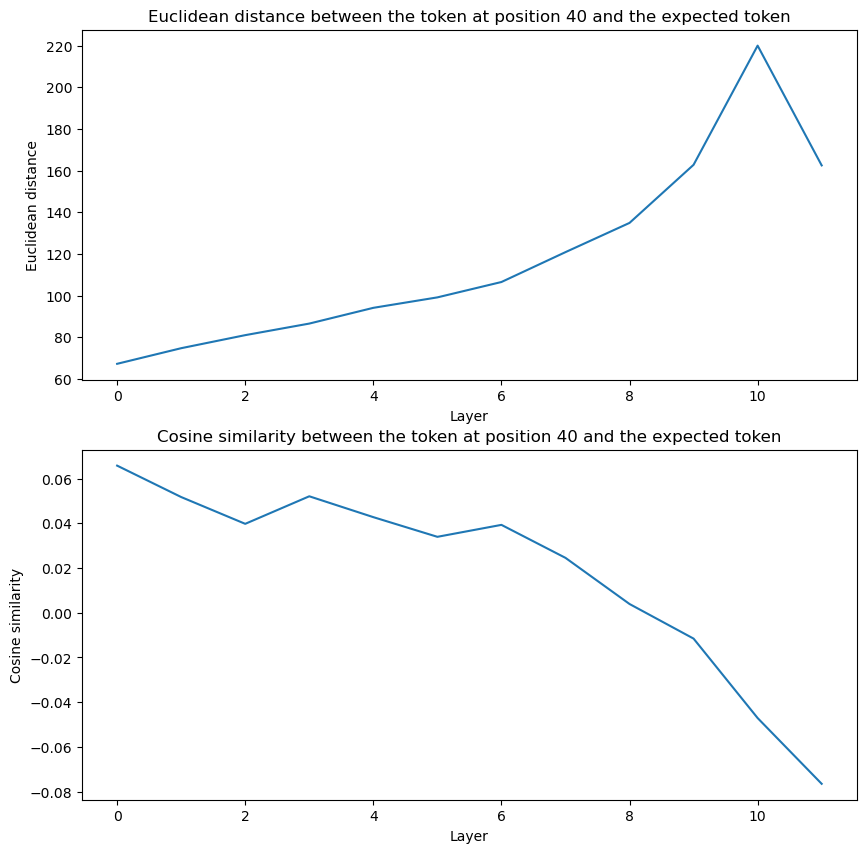

In [7]:
def get_tokens_prob(x, k=5):
    # Compute the similarity between the token and all the tokens in the vocabulary, then applies softmax
    prob = torch.softmax(torch.matmul(x,embeddings.T), dim=-1)
    # Get the top k tokens
    top = torch.topk(prob, k=k)
    idxs = top.indices
    tokens = [tokenizer.decode(idx) for idx in idxs]
    return top.values, idxs, tokens

X0 = layers[0][0]           # !!!!! X0 is not the initial embedding matrix, but the output of the first layer? Already soaked in w/ p.e. and context


traked_token = 40
print(f"EVOLUTION OF TOKEN {traked_token}, namely '{tokenizer.decode(encodedPrompt['input_ids'][0][traked_token])}'")
print(tokenizer.decode(inputs["input_ids"][0][:traked_token+1]), "...")

# embedding of the token at position traked_token+1 (to which the previous one should converge)
x_expected = embeddings[encodedPrompt["input_ids"][0][traked_token+1]] 

cosines=[]
euclideanDistances = []
# repeat for each layer
for i, layer in enumerate(layers):
    x = layer[0, traked_token]                                              # embedding of the token at position traked_token
    # compute the probs/logits starting from the selected token
    prob, idxs, tokens = get_tokens_prob(x, 10)
    print(f"\nLAYER {i} -----------------------------------")
    print(f"Expected: '{tokenizer.decode(encodedPrompt['input_ids'][0][traked_token+1])}'")
    print(f"Would have predicted at this layer:'{tokens[0]}'")
    cosine = torch.nn.functional.cosine_similarity(x, x_expected, dim=0)
    euclidean = torch.norm(x - x_expected)
    cosines.append(cosine)
    euclideanDistances.append(euclidean)
    print(f"Cos angle: {float(cosine):.3f}")
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")

max = -1.1
for emb in embeddings:
    if torch.nn.functional.cosine_similarity(x, emb, dim = -1) > max:
        max = torch.norm(torch.nn.functional.cosine_similarity(x, emb, dim = -1))
    
print(f"\nMax cosine similarity: {max:.3f}")
        


print("\n\n\n")
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(euclideanDistances)
ax[0].set_title("Euclidean distance between the token at position 40 and the expected token")
ax[0].set_xlabel("Layer")
ax[0].set_ylabel("Euclidean distance")

ax[1].plot(cosines)
ax[1].set_title("Cosine similarity between the token at position 40 and the expected token")
ax[1].set_xlabel("Layer")
ax[1].set_ylabel("Cosine similarity")

plt.show()

### MaxEnt approach

#### Boltzmann model

In [8]:
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo"
inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states
layers = hidden_states[1:]
 
# Next output token prediction
nextToken = (layers[-1][0])[-1]
# Given this representation of the next token, we project it into the vocabulary space and build a pdf on top of it using softmax
lengthQueue = 100
prob, idxs, tokens = get_tokens_prob(nextToken, lengthQueue)
print("Next token prediction:")
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

Next token prediction:
 -> logp = 0.28: [' Galile'], idx = 32422
 -> logp = 2.29: ['.'], idx = 13
 -> logp = 3.12: [' and'], idx = 290
 -> logp = 3.55: [','], idx = 11
 -> logp = 5.17: ['."'], idx = 526
 -> logp = 5.62: [' ('], idx = 357
 -> logp = 5.87: [' Galileo'], idx = 45860
 -> logp = 5.99: [' in'], idx = 287
 -> logp = 6.42: [' I'], idx = 314
 -> logp = 6.75: [' de'], idx = 390
 -> logp = 6.79: [' of'], idx = 286
 -> logp = 7.04: [',"'], idx = 553
 -> logp = 7.05: [';'], idx = 26
 -> logp = 7.08: [' L'], idx = 406
 -> logp = 7.08: [' II'], idx = 2873
 -> logp = 7.13: [' G'], idx = 402
 -> logp = 7.17: [' but'], idx = 475
 -> logp = 7.29: [' III'], idx = 6711
 -> logp = 7.32: [' who'], idx = 508
 -> logp = 7.38: [' F'], idx = 376
 -> logp = 7.50: [' V'], idx = 569
 -> logp = 7.50: [' C'], idx = 327
 -> logp = 7.60: [' .'], idx = 764
 -> logp = 7.62: [' because'], idx = 780
 -> logp = 7.64: [' -'], idx = 532
 -> logp = 7.67: [' as'], idx = 355
 -> logp = 7.71: [' on'], idx = 319
 

Following the MaxEnt approach, we arrive at the crucial step, i.e. the vector $\vec\mu$. Once we computed that, we can build the M.E. pdf $p(\vec x | \vec e_i)$

In [9]:
from scipy.optimize import fsolve

# solver function
def func(x,k):
    return 1 / np.tanh(x) - 1 / x - k

# We need to constraint the mean value of the distribution to be equal to the expected value of the token
tokenExpected = embeddings[32422]

mu = torch.tensor(np.zeros(embeddings.shape[1]), dtype=torch.float32)
for i,d in enumerate(tokenExpected):
    xi = d.item()
    mu_i = fsolve(func, 1, args=(xi))
    mu[i] = (mu_i.item())

print(f"Succesfully computed mu vector.")
print("It represents the direction of maximum probability; projecting mu over the vocabolary we get: \n")
# mu should be the direction of maximum probability. At what does it point to?
prob, idxs, tokens = get_tokens_prob(mu, 3)
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

print("\nAs expected, it points practically with certainty to the right expected token")

Succesfully computed mu vector.
It represents the direction of maximum probability; projecting mu over the vocabolary we get: 

 -> logp = -0.00: [' Galile'], idx = 32422
 -> logp = 38.92: [' Canaver'], idx = 46858
 -> logp = 40.84: ['Palest'], idx = 32570

As expected, it points practically with certainty to the right expected token


Now, since we have $\vec\mu$, we also have the analitical pdf. Let's compute the value of it on the same tokens obtained above

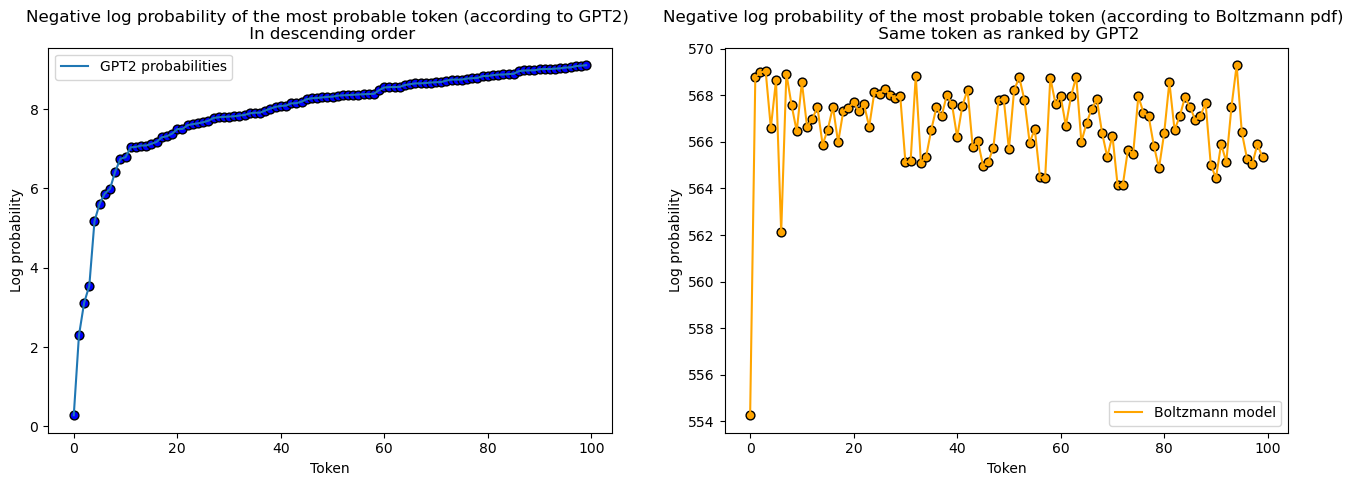

In [10]:
prob, idxs, tokens = get_tokens_prob(nextToken, lengthQueue)

def logprobBoltzmann(x):
    x = x / np.linalg.norm(x)
    unnorm = np.dot(x, mu)
    logterms = -np.log( mu.numpy() / (2 * np.sinh(mu.numpy())) )
    logZ = np.sum(logterms)
    return unnorm - logZ

probBolztmann = np.zeros(lengthQueue)   
for k,tkn in enumerate(embeddings[idxs]):
    #print(logprobBoltzmann(tkn.numpy()), -torch.log(prob[k]).item(), tokens[k])
    probBolztmann[k] = logprobBoltzmann(tkn.numpy())

fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[1].plot(-probBolztmann, label="Boltzmann model", c = "orange")
ax[1].scatter(range(len(probBolztmann)), -probBolztmann, color="orange", edgecolor="black", s=40)
ax[0].plot(-torch.log(prob).numpy(), label="GPT2 probabilities")
ax[0].scatter(range(len(prob)), -torch.log(prob).numpy(), color="blue", edgecolor="black", s=40)
ax[0].set_title("Negative log probability of the most probable token (according to GPT2) \n In descending order")
ax[0].set_xlabel("Token")
ax[0].set_ylabel("Log probability")
ax[0].legend()
ax[1].set_xlabel("Token")
ax[1].set_ylabel("Log probability")
ax[1].legend()
ax[1].set_title("Negative log probability of the most probable token (according to Boltzmann pdf) \n Same token as ranked by GPT2")
plt.show()

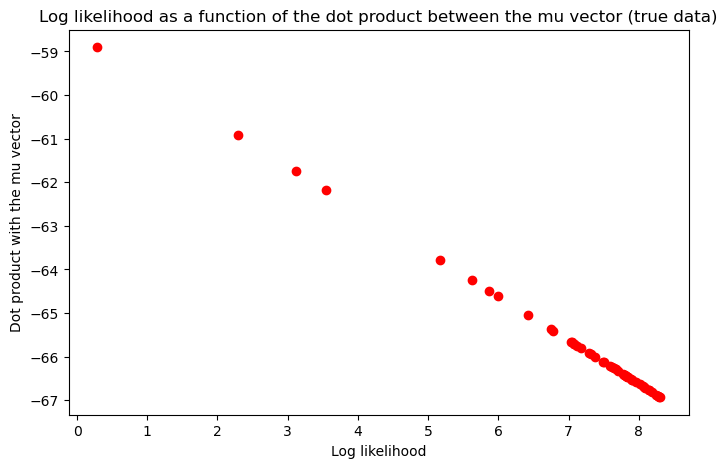

In [11]:
# Now let's see if the distribution is exponential in the dot product:
prob, idxs, tokens = get_tokens_prob(nextToken, 50)

probs = []
dps = []
for p, idx, token in zip(prob, idxs, tokens):
    probs.append(-torch.log(p).item())
    dps.append(torch.matmul(nextToken, embeddings[idx]).item())
    #dps.append(torch.nn.functional.cosine_similarity(nextToken, embeddings[idx], dim = -1).item())

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(probs, dps, c="r")
ax.set_title("Log likelihood as a function of the dot product between the mu vector (true data)")
ax.set_xlabel("Log likelihood")
ax.set_ylabel("Dot product with the mu vector")
plt.show()

Questa roba è esattamente quanto predice il modello alla Bolztmann (ma penso sia per come è definita viene calcolata la probabilità che sarà evidentemente proporzionale al prodotto scalare)

WORK IN PROGRESS DA QUI

## Second approach to constraining the entropy

Now let's try with the second approach

In [72]:
from scipy.linalg import solve
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect." \
" I was born in 1879 and died in 1955. My name is Einstein"

inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

layers = hidden_states[1:]
# attentions is a tuple of tensors. Each tensor is 12 attention maps of 16x16 matrices.
attentions = outputs.attentions

n = len(inputs["input_ids"][0])    # total number of tokens in the input

lastStepAttentionMatrices = attentions[11][0]
vectorA = torch.tensor(np.zeros(n-1))              # Not the last token (itself w/ itself)
#iterate on the heads
for head in range(12):
    attentionHead = lastStepAttentionMatrices[head]
    column = attentionHead[-1,:]
    column = column[:-1]
    vectorA = vectorA + column

T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
E = torch.matmul(T,embeddings)

# So now we have both vectorA and matrix E

In [89]:
import numpy as np
from scipy.optimize import fsolve, least_squares

# Definizione della funzione f componente per componente
def f(z):
    out = np.zeros_like(z)
    small = np.abs(z) < 1e-6
    out[small] = 0  # limite per z → 0
    out[~small] = 1/z[~small] - 1/np.tanh(z[~small])
    return out

# Sistema da risolvere
def system(x, E, A):
    E = E[:-1, :]
    z = np.dot(E.T, x)           # Calcolo E^t * x 
    z = z.reshape(-1)      # Appiattisci z
    fz = f(z)               # Applica f componente per componente
    fz = fz.reshape(-1, 1)      # Assicurati che fz sia una matrice colonna
    v = E @ fz
    v = v.reshape(-1)      # Appiattisci v
    return v - A       # Calcola f(z) * E - A (sistema = 0)

x0 = 105*np.ones(n-1)              # Stima iniziale
# Risoluzione

mu = fsolve(system, x0, args=(E.numpy(), vectorA.numpy()))
#mu = least_squares(system, x0, args=(E.numpy(), vectorA.numpy()))

x_expected = f((E[:-1, :]).T @ mu)

prob, idxs, tokens = get_tokens_prob(torch.tensor(x_expected, dtype = torch.float), 15)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")

 -> 1.17: 'ainer'
 -> 1.62: 'German'
 -> 1.81: 'Dutch'
 -> 3.04: 'Moh'
 -> 3.84: 'Lord'
 -> 3.88: 'Die'
 -> 3.98: ' German'
 -> 4.35: 'Aust'
 -> 4.46: 'Ah'
 -> 4.63: 'Um'
 -> 4.97: 'Bey'
 -> 5.01: ' Austrian'
 -> 5.13: 'Germany'
 -> 5.17: 'ILLE'
 -> 5.18: 'vre'


/tmp/ipykernel_6200/780160135.py:26: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  mu = fsolve(system, x0, args=(E.numpy(), vectorA.numpy()))
